In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from 'C:\\Users\\Ludwig\\miniconda3\\envs\\gammapy-1.0-irf\\lib\\site-packages\\gammapy\\__init__.py'>


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : dxyKPp4V 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 550694.17
  Predicted background counts     : 533641.14
  Predicted excess counts         : 17053.03

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2299469.75

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 13

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal 

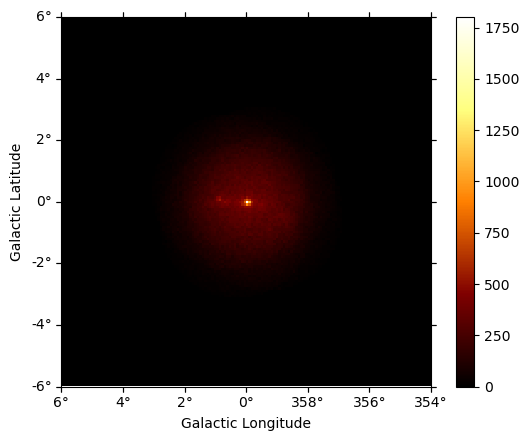

In [3]:
source = 'Galactic Centre'
path = 'C:/Users/yt02izug/Downloads'

dataset_standard = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
#dataset_standard = dataset_standard.downsample(4)
#models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/data/1_model_standard_best_fit_mask.yml")

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
#Values from dataset_standard best fit (without nuisance)
diff.parameters['tilt'].value = 0.07545879357806834
diff.parameters['tilt'].error = 0.02658390520205726
diff.parameters['norm'].value = 2.8506776847212123
diff.parameters['norm'].error = 0.08440779649209731
diff.parameters['tilt'].frozen = False
models.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_standard.models[0].parameters['lon_0'].min = dataset_standard.models[0].parameters['lon_0'].value - 1
dataset_standard.models[0].parameters['lon_0'].max = dataset_standard.models[0].parameters['lon_0'].value + 1
dataset_standard.models[0].parameters['lat_0'].min = dataset_standard.models[0].parameters['lat_0'].value - 1
dataset_standard.models[0].parameters['lat_0'].max = dataset_standard.models[0].parameters['lat_0'].value + 1
dataset_standard.models[1].parameters['lon_0'].min = dataset_standard.models[1].parameters['lon_0'].value - 1
dataset_standard.models[1].parameters['lon_0'].max = dataset_standard.models[1].parameters['lon_0'].value + 1
dataset_standard.models[1].parameters['lat_0'].min = dataset_standard.models[1].parameters['lat_0'].value - 1
dataset_standard.models[1].parameters['lat_0'].max = dataset_standard.models[1].parameters['lat_0'].value + 1
#dataset_standard.models[0].parameters['lon_0'].frozen = True
#dataset_standard.models[0].parameters['lat_0'].frozen = True
#dataset_standard.models[1].parameters['lon_0'].frozen = True
#dataset_standard.models[1].parameters['lat_0'].frozen = True


#create asimov dataset
dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(dataset_standard.models.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models


#Input Model for Comparison
dataset_input = dataset_standard.copy()
models_input = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
models_input.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_input.name)
bkg_model.parameters['tilt'].frozen  = False
models_input.append(bkg_model)
dataset_input.models = models

#set mask to exclude J1745
j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')
skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)#, angle = 108*u.deg)
geom = dataset_standard.counts.geom
mask_space = ~geom.region_mask([skyregion_1745])
dataset_standard.mask_fit = mask_space
dataset_asimov.mask_fit = mask_space

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)
#print(dataset_asimov)

## Asimov Cases

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

# energy independent method: pm 10%
shift_neg = -0.1#-0.085
shift_pos = 0.1#+0.085
shift_cor = 0.0

tilt_neg = -0.015 # 1e-24 for computational purposes -> covmatrix "1/0"
tilt_pos = 0.015
tilt_cor = 0.

print(tilt_neg)

-0.015


In [5]:
sys_d_cor = sys_dataset(dataset_asimov, shift_cor, tilt_cor, False)
dataset_cor_N = sys_d_cor.create_dataset_N()

sys_d_neg = sys_dataset(dataset_asimov, shift_neg, tilt_neg, False)
dataset_neg_N = sys_d_neg.create_dataset_N()

sys_d_pos = sys_dataset(dataset_asimov, shift_pos, tilt_pos, False)
dataset_pos_N = sys_d_pos.create_dataset_N()

zero = 1e-24
# additional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/(shift_neg)**2, 1/(tilt_neg)**2, 1/zero**2, 1/zero**2])
    
dataset_pos_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_neg_N.penalising_invcovmatrix = penalising_invcovmatrix

datasets  = [dataset_pos_N, dataset_cor_N, dataset_neg_N]

print(datasets[1])

MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 550694 
  Total background counts         : 533641.19
  Total excess counts             : 17052.98

  Predicted counts                : 550697.23
  Predicted background counts     : 533641.14
  Predicted excess counts         : 17056.09

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 100300 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2160804.01

  Number of models                : 5 
  Number of parameters            : 23
  Number of free parameters       : 15

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Para

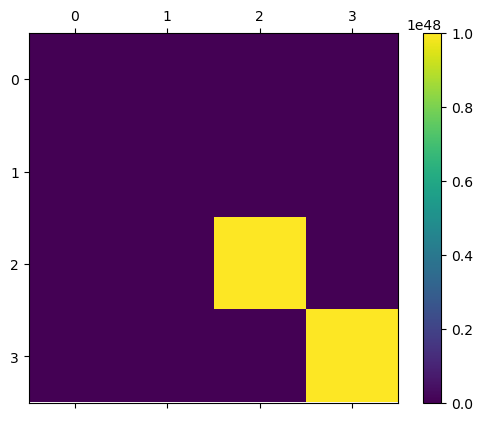

In [6]:
fig, ax = plt.subplots(1,1)
#ax = fig.add_subplot(111)
cax = ax.matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);
#cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
#fig.colorbar(cax);

corr
neg
pos
CPU times: total: 8h 37min 50s
Wall time: 1h 30min 39s


<AxesSubplot: >

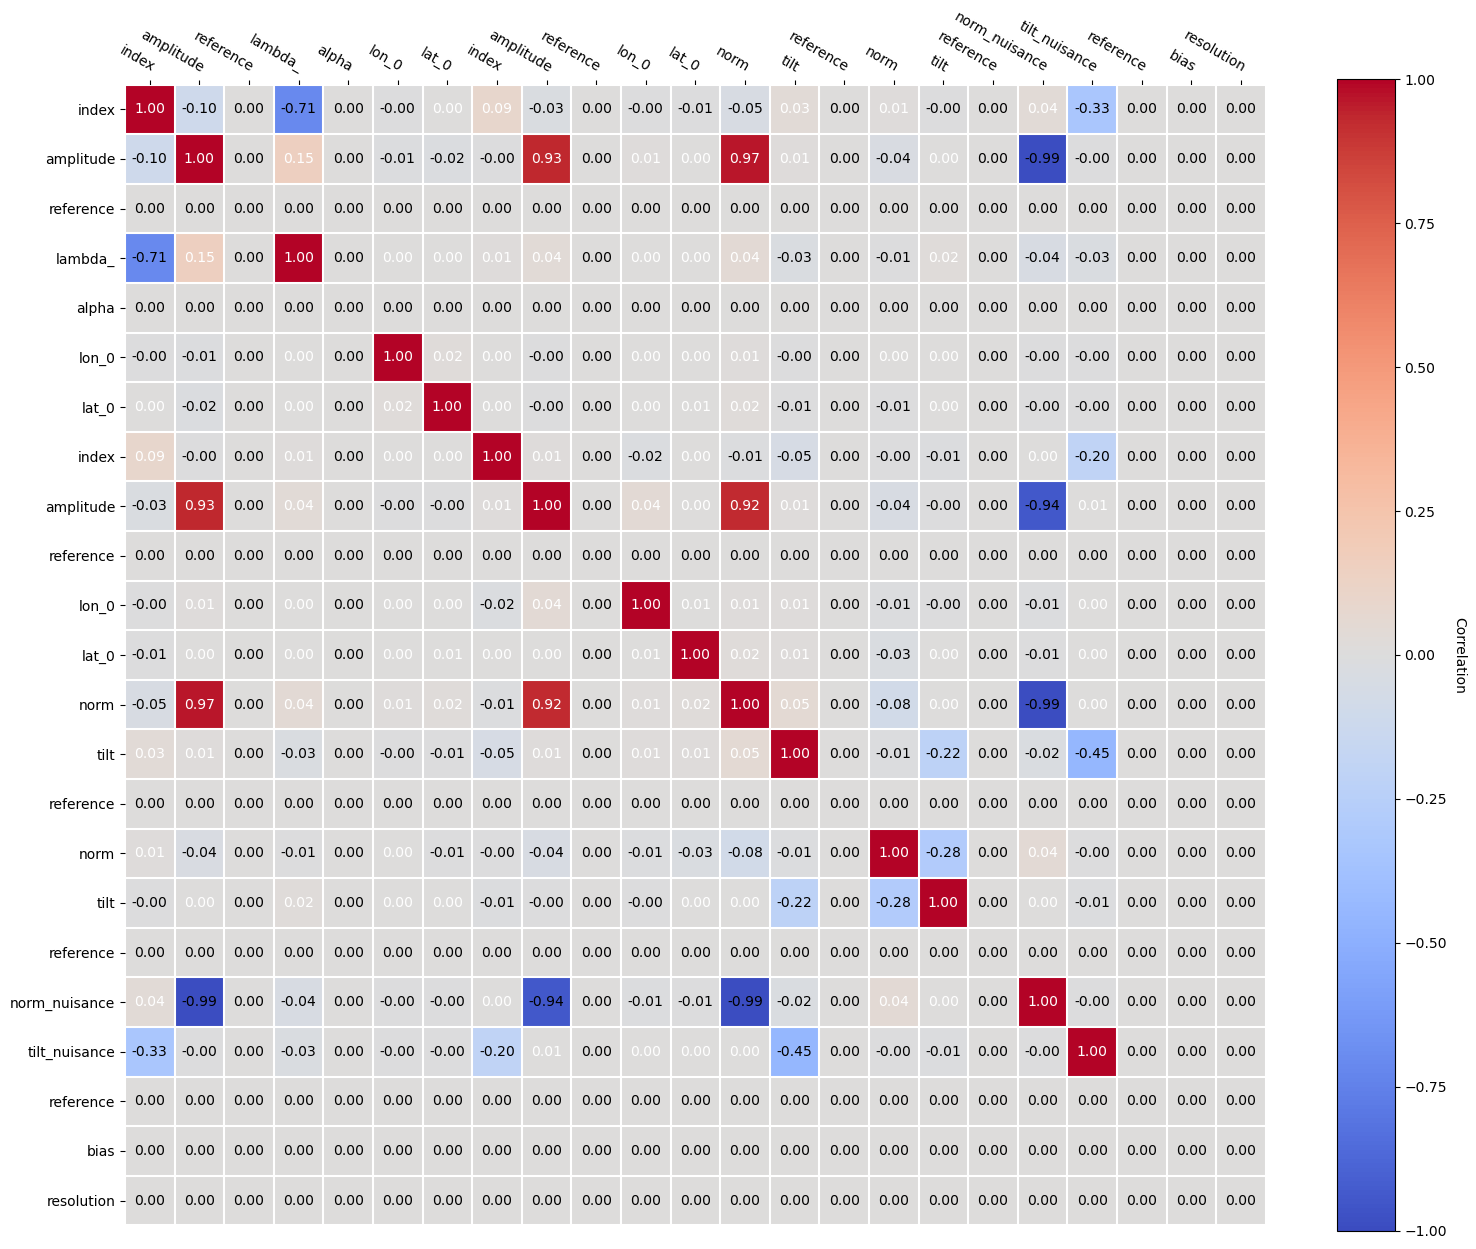

In [7]:
%%time
print("corr")
fit_cor = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.backend = "minuit"
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run(dataset_cor_N)
        
print("neg")
fit_neg = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_neg.backend = "minuit"
fit_neg.optimize_opts = minuit_opts
result_neg = fit_neg.run(dataset_neg_N)

print("pos")
fit_pos = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_pos.backend = "minuit"
fit_pos.optimize_opts = minuit_opts
result_pos = fit_pos.run(dataset_pos_N)

dataset_cor_N.models.covariance = fit_cor.covariance(dataset_cor_N).matrix
dataset_cor_N.models.covariance.plot_correlation()

#dataset_neg_N.models.covariance = fit_neg.covariance(dataset_neg_N).matrix
#dataset_neg_N.models.covariance.plot_correlation()

#dataset_pos_N.models.covariance = fit_pos.covariance(dataset_pos_N).matrix
#dataset_pos_N.models.covariance.plot_correlation()

In [8]:
datasets_short = [dataset_neg_N, dataset_cor_N, dataset_pos_N]
print("Best Fit Amplitude")
amplitudes_N = []
m = dataset_asimov.models[0]
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[0]
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes_N.append((value, error))
    print(f'{value} pm {error}')
print()
print("Best Fit Index")
indices_N = []
m = dataset_asimov.models[0]
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[0]
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices_N.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit Bkg Norm")
norms_N = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms_N.append((value, error))
print()   
    
print("Best Fit Lambda")
lambdas_N = []
value = dataset_asimov.models.parameters['lambda_'].value 
error = dataset_asimov.models.parameters['lambda_'].error
lambdas_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.models.parameters['lambda_'].value 
    error = d.models.parameters['lambda_'].error
    print(f'{value} pm {error}')
    lambdas_N.append((value, error))

Best Fit Amplitude
====
Input
2.733011434009236e-12 pm 8.262906868322266e-14
====
3.041416034686941e-12 pm 5.571215528772641e-13
2.7332998641489082e-12 pm 5.006992425786992e-13
2.486553450065743e-12 pm 4.555472449920006e-13

Best Fit Index
====
Input
2.030101390516945 pm 0.039401465836845215
====
2.044209503095618 pm 0.04096700448497908
2.0299734824441127 pm 0.04093008557078066
2.014905917377678 pm 0.040956917328330754

Best Fit bkg Norm
====
Input
1.0 pm 0
====
1.0000001420481306 pm 0.001512798781808451
0.9999999276313941 pm 0.0015128525042594106
1.0000037894618372 pm 0.0015129225619616594

Best Fit Lambda
====
Input
0.08874510187310557 pm 0.013347642968012784
====
0.08920611539337714 pm 0.01395412662679929
0.08880494196147436 pm 0.013913310141189681
0.08894100840079774 pm 0.01393376500772959


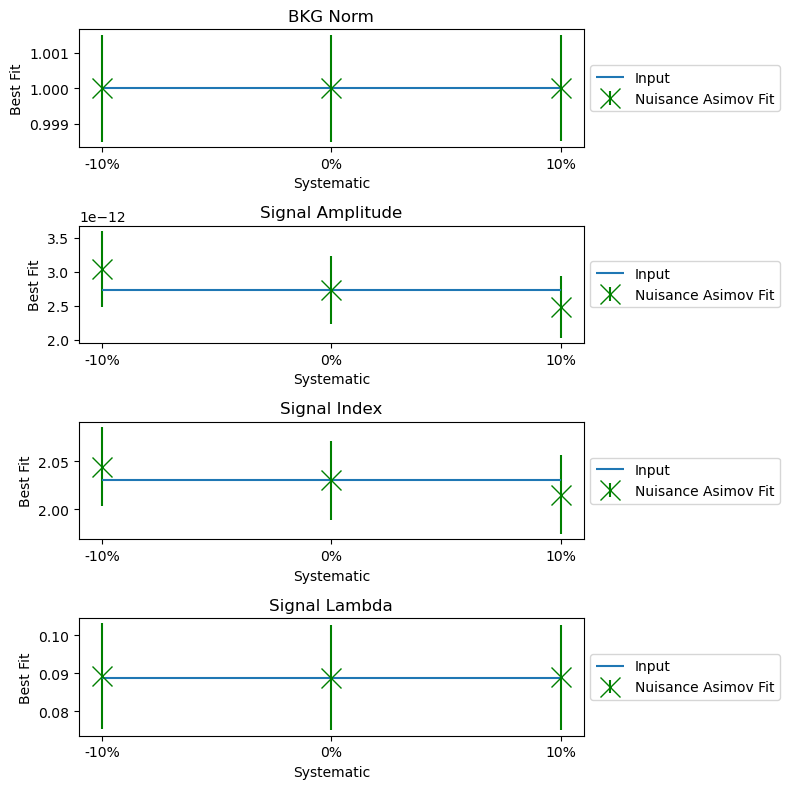

In [9]:
fig, axs = plt.subplots(4,1, figsize=(8,8))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")
axs[3].set_title("Signal Lambda")


labels_sys = ['-10%', '0%', '10%']
label = "Nuisance Asimov Fit"

for i, a in enumerate(norms_N[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[0].hlines( norms_N[0][0], 1, 3, label = "Input")

for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[1].hlines( amplitudes_N[0][0], 1, 3, label = "Input")

for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices_N[0][0], 1, 3, label = "Input")

for i, a in enumerate(lambdas_N[1:]):
    axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[3].hlines(lambdas_N[0][0], 1, 3, label = "Input")

plt.tight_layout()
for a in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    
fig.savefig("best_fit_parameters_corr.pdf")   


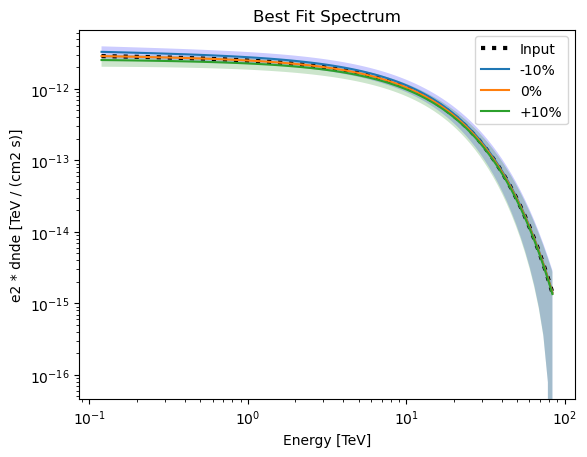

In [10]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                               label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "-10%")
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='blue')

dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "0%")
                                   
#dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                       facecolor='orange')


                               
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "+10%")
dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                        facecolor = 'green')


plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
#fig.savefig("plots/2_spectrum.pdf")

In [11]:
#print(dataset_asimov)

-0.0009250370618382425 0.18007660390945127
-2.312895426608049e-07 0.18025377671633902
-0.00035428534339433307 0.18019536167027755
-0.00011264622775815417 0.01446726185383852
2.0838456267353307e-07 0.014468945477918537
-0.00014553462434303117 0.014469313191354112
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


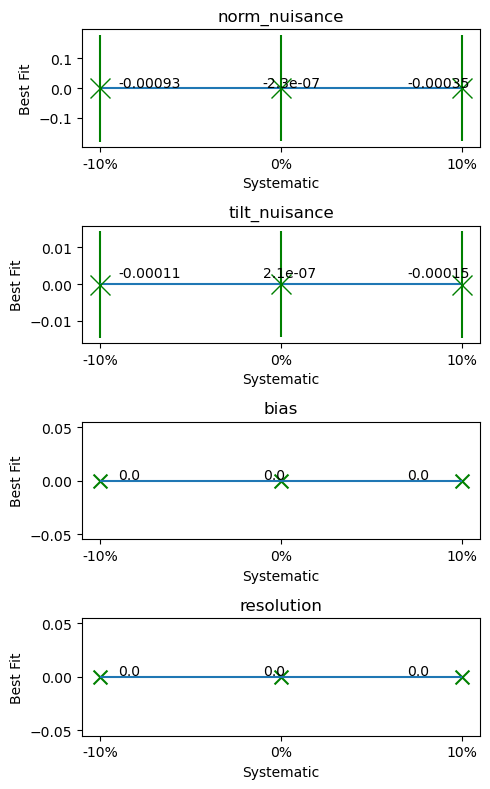

In [12]:
n_nui = len(dataset_neg_N.models.parameters.penalised_parameters)
fig, a  = plt.subplots(n_nui, 1, figsize = (5,2* n_nui))
if n_nui ==1:
    a = [a]
label = 'Nuisance Fit'
iss = [1.1, 1.9, 2.7]
for j, par_name in enumerate(dataset_neg_N.models.parameters.penalised_parameters.names):
    for i, d in enumerate([dataset_neg_N, dataset_cor_N, dataset_pos_N]):
        value = d.models.parameters[par_name].value
        error = d.models.parameters[par_name].error
        print(value, error)
        if error > 1e-24:
            a[j].errorbar(x= i+1, y = value, yerr = error, fmt= 'x', color = 'green', markersize=14,
                       label = label)
        else:
            a[j].scatter(i+1, value, color = 'green', marker = 'x', s=100,
                       label = label)
        a[j].text(iss[i],0.002, f'{value:.2}', )
    a[j].hlines( 0., 1, 3, label = "input")
    
    a[j].set_ylabel('Best Fit' ); 
    a[j].set_title(par_name)
    a[j].set_xlabel('Systematic'); 
    a[j].set_xticks(np.arange(3)+1,labels_sys);

plt.tight_layout()
#fig.savefig("plots/2_best_fit_nui.pdf")

## Comparison

In [13]:

with open('data/1_norms.yaml') as file:
    norms = yaml.load( file, Loader=yaml.FullLoader)
with open('data/1_amplitudes.yaml') as file:
    amplitudes = yaml.load( file, Loader=yaml.FullLoader)
with open('data/1_indices.yaml') as file:
    indices = yaml.load( file, Loader=yaml.FullLoader)
with open('data/1_lambdas.yaml') as file:
    lambdas = yaml.load( file, Loader=yaml.FullLoader)


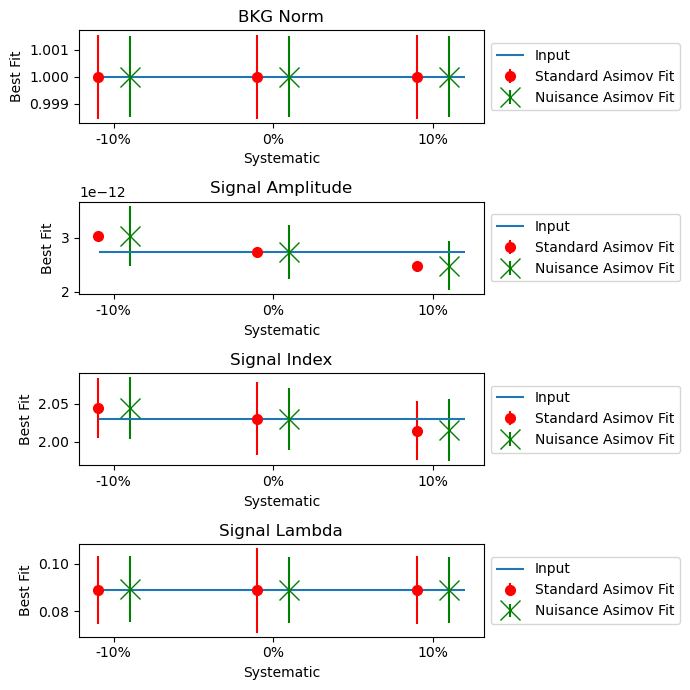

In [14]:
fig, axs = plt.subplots(4,1, figsize= (7, 7))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")
axs[3].set_title("Signal Lambda")


labels_sys = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    label = "Standard Asimov Fit"
    axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(lambdas[1:]):
    axs[3].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
    
for i, a in enumerate(norms_N[1:]):
    label = "Nuisance Asimov Fit"
    axs[0].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(lambdas_N[1:]):
    axs[3].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices[0][0], 0.91, 3.2, label = "Input")
axs[0].hlines( norms[0][0], 0.91, 3.2, label = "Input")
axs[1].hlines( amplitudes[0][0], 0.91, 3.2, label = "Input")
axs[3].hlines( lambdas[0][0], 0.91, 3.2, label = "Input")

plt.tight_layout()
for ax in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(3)+1,labels_sys)

    
#axs[0].set_ylim(0.85, 1.15)
plt.tight_layout()    
fig.savefig("plots/2_best_fit_parameters_comparison.pdf")   


### Spectrum

In [15]:
# diff = Map.read(f'{path}/diffusetemplate.fits')
# new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
# diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
# temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
# diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())

dataset_st_neg = dataset_neg_N.copy()
dataset_st_neg.models = Models.read("data/1_model_neg.yml")
# dataset_st_neg.models.append(diff)

dataset_st_pos = dataset_pos_N.copy()
dataset_st_pos.models = Models.read("data/1_model_pos.yml")
# dataset_st_pos.models.append(diff)

dataset_st_cor = dataset_cor_N.copy()
dataset_st_cor.models = Models.read("data/1_model_cor.yml")
# dataset_st_cor.models.append(diff)

In [16]:
for d in datasets:
    for p in d.models.parameters.penalised_parameters:
        p.frozen = True

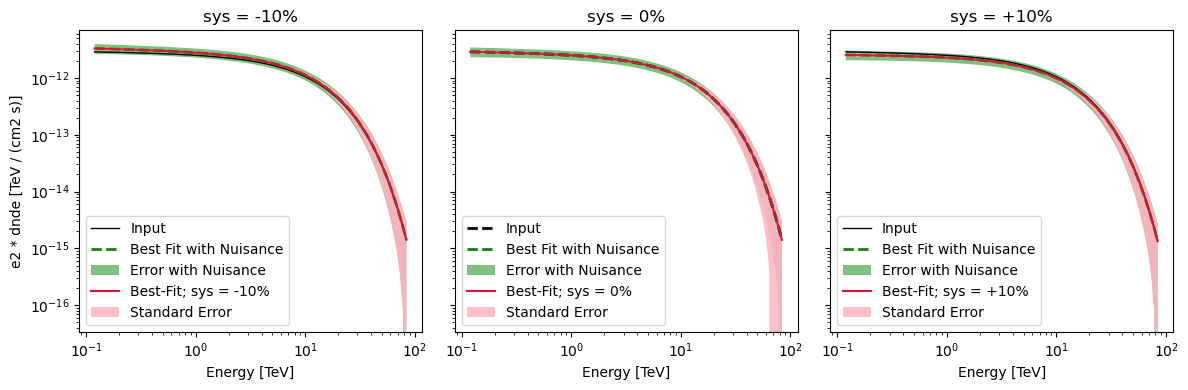

In [17]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )


dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
## cor 
dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],color = 'green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_cor_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_st_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### pos 
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],color = 'green',
                                                               label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)                                              

dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_st_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                      facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.pdf")

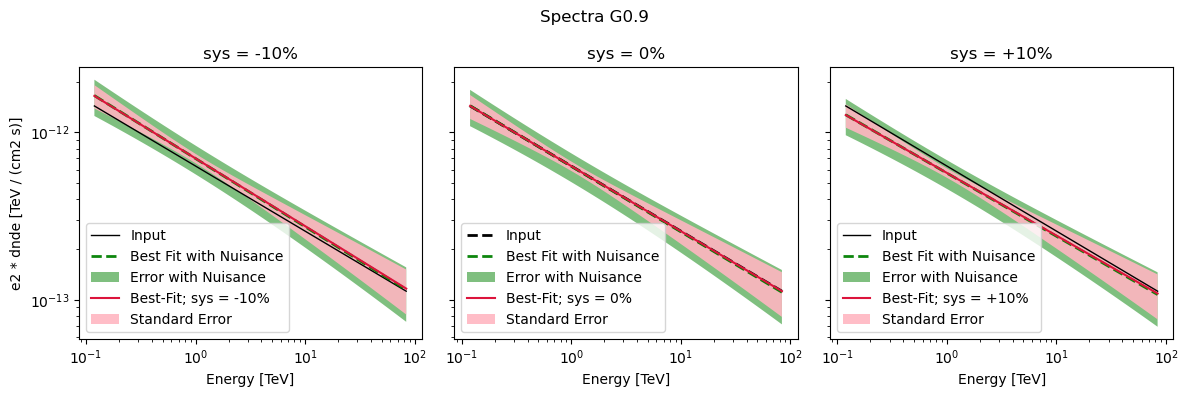

In [21]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[1].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[1].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )


dataset_neg_N.models[1].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_neg_N.models[1].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_neg.models[1].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_st_neg.models[1].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
## cor 
dataset_cor_N.models[1].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],color = 'green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_cor_N.models[1].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_cor.models[1].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_st_cor.models[1].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### pos 
dataset_pos_N.models[1].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],color = 'green',
                                                               label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)                                              

dataset_pos_N.models[1].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_pos.models[1].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_st_pos.models[1].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                      facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.suptitle('Spectra G0.9')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison_G09.pdf")

In [18]:
print(dataset_cor_N)

MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 550694 
  Total background counts         : 533641.19
  Total excess counts             : 17052.98

  Predicted counts                : 550694.19
  Predicted background counts     : 533641.24
  Predicted excess counts         : 17052.95

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 100300 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2160804.02

  Number of models                : 5 
  Number of parameters            : 23
  Number of free parameters       : 13

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Para